# Assignment 2: Deep Q Learning and Policy Gradient

*CS260R: Reinforcement Learning. Department of Computer Science at University of California, Los Angeles.
Course Instructor: Professor Bolei ZHOU. Assignment author: Zhenghao PENG.*



| Student Name | Student ID |
| :----: | :----: |
| TYPE_YOUR_NAME_HERE | TYPE_YOUR_STUDENT_ID_HERE |

------

Welcome to the assignment 2 of our RL course. This assignment consisits of three parts:

* Section 2: Implement Q learning in tabular setting (20 points)
* Section 3: Implement Deep Q Network with pytorch (30 points)
* Section 4: Implement policy gradient method REINFORCE with pytorch (30 points)
* Section 5: Implement policy gradient method with baseline (20 points)

Section 0 and Section 1 set up the dependencies and prepare some useful functions.

The experiments we'll conduct and their expected goals:

1. Naive Q learning in FrozenLake &emsp; (should solve)
2. DQN in CartPole &emsp; (should solve)
3. DQN in MetaDrive-Easy &emsp; (should solve)
4. Policy Gradient w/o baseline in CartPole (w/ and w/o advantage normalization) &emsp; (should solve)
5. Policy Gradient w/o baseline in MetaDrive-Easy &emsp; (should solve)
6. Policy Gradient w/ baseline in CartPole (w/ advantage normalization) &emsp; (should solve)
7. Policy Gradient w/ baseline in MetaDrive-Easy &emsp; (should solve)
8. Policy Gradient w/ baseline in MetaDrive-Hard &emsp; (>20 return)

## Section 0: Dependencies

Please install the following dependencies.


### Notes on MetaDrive

MetaDrive is a lightweight driving simulator which we will use for DQN and Policy Gradient methods. We suggest using Colab or Linux for running MetaDrive.

Please ignore this warning from MetaDrive: `WARNING:root:BaseEngine is not launched, fail to sync seed to engine!`

### Notes on Colab

We have several cells used for installing dependencies for Colab only. Please make sure they are run properly.

You don't need to install python packages again and again after **restarting the runtime**, since the Colab instance still remembers the python envionment after you installing packages for the first time. But you do need to rerun those packages installation script after you **reconnecting to the runtime** (which means Google assigns a new machine to you and thus the python environment is new).

In [1]:
from sympy.physics.quantum.matrixutils import to_numpy

RUNNING_IN_COLAB = 'google.colab' in str(get_ipython())  # Detect if it is running in Colab

In [2]:
# Similar to AS1

!pip install -U pip
!pip install numpy scipy "gymnasium<0.29"
!pip install torch torchvision
!pip install mediapy
!pip install tqdm

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\lucaslan\miniconda3\envs\rl\python.exe -m pip install -U pip


   ---------------------------------------- 0.0/925.5 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/925.5 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 925.5/925.5 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1


In [3]:
# Install MetaDrive, a lightweight driving simulator

import sys

!pip install "git+https://github.com/metadriverse/metadrive"

  Cloning https://github.com/metadriverse/metadrive to c:\users\lucaslan\appdata\local\temp\pip-req-build-w_tshu8j
  Resolved https://github.com/metadriverse/metadrive to commit 13befc8e6ddc5f3ffe907073007fb3ea187d87db
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/64.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/64.4 MB 8.5 MB/s eta 0:00:08
   - -------------------------------------- 2.1/64.4 MB 7.8 MB/s eta 0:00:08
   - -------------------------------------- 2.1/64.4 MB 7.8 MB/s eta 0:00:08
   - -------------------------------------- 2.6/64.4 MB 3.4 MB/s eta 0:00:19
   - -------------------------------------- 3.1/64.4 MB 4.0 MB/s eta 0:00:16
   -- ------------------------------------

  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive 'C:\Users\lucaslan\AppData\Local\Temp\pip-req-build-w_tshu8j'


In [4]:
# Test whether MetaDrive is properly installed. The test is passed if no error is shown.
!python -m metadrive.examples.profile_metadrive --num-steps 100

Start to profile the efficiency of MetaDrive with 1000 maps and ~4 vehicles!
Finish 100/100 simulation steps. Time elapse: 0.2372. Average FPS: 970.6565, Average number of vehicles: 6.0000
Total Time Elapse: 0.237, average FPS: 970.657, average number of vehicles: 6.000.


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[WARNING] Assets folder doesn't exist. Begin to download assets... (base_engine.py:773)
[INFO] Pull assets from https://github.com/metadriverse/metadrive/releases/download/MetaDrive-0.4.3/assets.zip to C:\Users\lucaslan\miniconda3\envs\rl\Lib\site-packages\metadrive\assets.zip
  0% |                                                                        |
  1% |                                                                        |
  2% |#                                                                       |
  3% |##                                                                      |
  4% |##                                                                      |
  5% |###                                                                     |
  6% 

## Section 1: Building abstract class and helper functions

In [1]:
# Run this cell without modification

# Import some packages that we need to use
import mediapy as media
import gymnasium as gym
import numpy as np
import pandas as pd
import seaborn as sns
from gymnasium.error import Error
from gymnasium import logger
import torch
import torch.nn as nn
from IPython.display import clear_output
import copy
import time
import pygame
import logging
import tqdm

logging.basicConfig(format='[%(levelname)s] %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)


def wait(sleep=0.2):
    clear_output(wait=True)
    time.sleep(sleep)


def merge_config(new_config, old_config):
    """Merge the user-defined config with default config"""
    config = copy.deepcopy(old_config)
    if new_config is not None:
        config.update(new_config)
    return config


def test_random_policy(policy, env):
    _acts = set()
    for i in range(1000):
        act = policy(0)
        _acts.add(act)
        assert env.action_space.contains(act), "Out of the bound!"
    if len(_acts) != 1:
        print(
            "[HINT] Though we call self.policy a 'random policy', " \
            "we find that generating action randomly during initialization " \
            "and then sticking with it when update values lead to better " \
            "performance. Using purely random policy is not even work! "
        )


# We register a non-slippery version of FrozenLake environment.
try:
    gym.register(
        id='FrozenLakeNotSlippery-v1',
        entry_point='gymnasium.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '4x4', 'is_slippery': False},
        max_episode_steps=200,
        reward_threshold=0.78,  # optimum = .8196
    )
except Error:
    print("The environment is registered already.")


def _render_helper(env, sleep=0.1):
    ret = env.render()
    if sleep:
        wait(sleep=sleep)
    return ret


def animate(img_array, fps=None):
    """A function that can generate video and show in Notebook."""
    media.show_video(img_array, fps=fps)


def evaluate(policy, num_episodes=1, seed=0, env_name='FrozenLake8x8-v1',
             render=None, existing_env=None, max_episode_length=1000,
             sleep=0.0, verbose=False):
    """This function evaluates the given policy and return the mean episodic 
    reward.
    :param policy: a function whose input is the observation
    :param num_episodes: number of episodes you wish to run
    :param seed: the random seed
    :param env_name: the name of the environment
    :param render: a boolean flag indicating whether to render policy
    :return: the averaged episode reward of the given policy.
    """
    if existing_env is None:
        render_mode = render if render else None
        env = gym.make(env_name, render_mode=render)
    else:
        env = existing_env
    try:
        rewards = []
        frames = []
        succ_rate = []
        if render:
            num_episodes = 1
        for i in range(num_episodes):
            obs, info = env.reset(seed=seed + i)
            act = policy(obs)
            ep_reward = 0
            for step_count in range(max_episode_length):
                obs, reward, terminated, truncated, info = env.step(act)
                done = terminated or truncated

                act = policy(obs)
                ep_reward += reward

                if verbose and step_count % 50 == 0:
                    print("Evaluating {}/{} episodes. We are in {}/{} steps. Current episode reward: {:.3f}".format(
                        i + 1, num_episodes, step_count + 1, max_episode_length, ep_reward
                    ))

                if render == "ansi":
                    print(_render_helper(env, sleep))
                elif render:
                    frames.append(_render_helper(env, sleep))
                if done:
                    break
            rewards.append(ep_reward)
            if "arrive_dest" in info:
                succ_rate.append(float(info["arrive_dest"]))
        if render:
            env.close()
    except Exception as e:
        env.close()
        raise e
    finally:
        env.close()
    eval_dict = {"frames": frames}
    if succ_rate:
        eval_dict["success_rate"] = sum(succ_rate) / len(succ_rate)
    return np.mean(rewards), eval_dict


In [2]:
# Run this cell without modification

DEFAULT_CONFIG = dict(
    seed=0,
    max_iteration=20000,
    max_episode_length=200,
    evaluate_interval=10,
    evaluate_num_episodes=10,
    learning_rate=0.001,
    gamma=0.8,
    eps=0.3,
    env_name='FrozenLakeNotSlippery-v1'
)


class AbstractTrainer:
    """This is the abstract class for value-based RL trainer. We will inherent
    the new trainer from this class, so that we can reuse the code.
    """

    def __init__(self, config):
        self.config = merge_config(config, DEFAULT_CONFIG)

        # Create the environment
        self.env_name = self.config['env_name']
        self.env = gym.make(self.env_name)

        # Apply the random seed
        self.seed = self.config["seed"]
        np.random.seed(self.seed)
        self.env.reset(seed=self.seed)

        # We set self.obs_dim to the number of possible observations
        # if observation space is discrete, otherwise the number
        # of observation's dimensions. The same applies to self.act_dim.
        if isinstance(self.env.observation_space, gym.spaces.box.Box):
            assert len(self.env.observation_space.shape) == 1
            self.obs_dim = self.env.observation_space.shape[0]
            self.discrete_obs = False
        elif isinstance(self.env.observation_space,
                        gym.spaces.discrete.Discrete):
            self.obs_dim = self.env.observation_space.n
            self.discrete_obs = True
        else:
            raise ValueError("Wrong observation space!")

        if isinstance(self.env.action_space, gym.spaces.box.Box):
            assert len(self.env.action_space.shape) == 1
            self.act_dim = self.env.action_space.shape[0]
        elif isinstance(self.env.action_space, gym.spaces.discrete.Discrete):
            self.act_dim = self.env.action_space.n
        else:
            raise ValueError("Wrong action space! {}".format(self.env.action_space))

        self.eps = self.config['eps']

    def process_state(self, state):
        """
        Process the raw observation. For example, we can use this function to
        convert the input state represented by an integer to a one-hot vector.
        """
        return state

    def compute_action(self, processed_state, eps=None):
        """Compute the action given the processed state."""
        raise NotImplementedError(
            "You need to override the Trainer.compute_action() function.")

    def evaluate(self, num_episodes=50, *args, **kwargs):
        """Use the function you write to evaluate current policy.
        Return the mean episode reward of 50 episodes."""
        if "MetaDrive" in self.env_name:
            kwargs["existing_env"] = self.env
        result, eval_infos = evaluate(self.policy, num_episodes, seed=self.seed,
                                      env_name=self.env_name, *args, **kwargs)
        return result, eval_infos

    def policy(self, raw_state, eps=0.0):
        """A wrapper function takes raw_state as input and output action."""
        return self.compute_action(self.process_state(raw_state), eps=eps)

    def train(self, iteration=None):
        """Conduct one iteration of learning."""
        raise NotImplementedError("You need to override the "
                                  "Trainer.train() function.")


In [3]:
import tqdm

In [4]:
# Run this cell without modification

def run(trainer_cls, config=None, reward_threshold=None):
    """Run the trainer and report learning progress.
    :param trainer_cls: A trainer class 
    :param config: A dict
    :param reward_threshold: the reward threshold to break the training
    :return: The trained trainer and a dataframe containing learning progress
    """
    if config is None:
        config = {}
    trainer = trainer_cls(config)
    config = trainer.config
    start = now = time.time()
    stats = []
    total_steps = 0
    reward = 0.0

    try:
        pbar = tqdm.trange(config['max_iteration'] + 1, desc="Training")
        for i in pbar:
            stat = trainer.train(iteration=i)
            stat = stat or {}
            stats.append(stat)
            if "episode_len" in stat:
                total_steps += stat["episode_len"]
            if i % config['evaluate_interval'] == 0 or \
                    i == config["max_iteration"]:
                reward, _ = trainer.evaluate(
                    config.get("evaluate_num_episodes", 50),
                    max_episode_length=config.get("max_episode_length", 1000)
                )
                now = time.time()
                pbar.set_postfix({'ep_reward': reward})
            if reward_threshold is not None and reward > reward_threshold:
                logger.info("Iter {}, episodic return {:.3f} is "
                            "greater than reward threshold {}. Congratulation! Now we "
                            "exit the training process.".format(i, reward, reward_threshold))
                break
    except Exception as e:
        print("Error happens during training: ")
        raise e
    finally:
        if hasattr(trainer.env, "close"):
            trainer.env.close()
            print("Environment is closed.")

    return trainer, stats


## Section 2: Q-Learning
(20/100 points)

Q-learning is an off-policy algorithm who differs from SARSA in the TD error. 

Unlike getting the TD error by running policy to get `next_act` $a'$ and compute:

$r + \gamma Q(s', a') - Q(s, a)$

as in SARSA, in Q-learning we compute the TD error via:

$r + \gamma \max_{a'} Q(s', a') - Q(s, a)$. 

The reason we call it "off-policy" is that the next-Q value is not computed against the "behavior policy", instead, it is the next Q value of a "hypothetical policy" that always takes the best action given current Q values.

### Section 2.1: Building Q Learning Trainer

In [5]:
# Solve the TODOs and remove `pass`

# Managing configurations of your experiments is important for your research.
Q_LEARNING_TRAINER_CONFIG = merge_config(dict(
    eps=0.3,
), DEFAULT_CONFIG)


class QLearningTrainer(AbstractTrainer):
    def __init__(self, config=None):
        config = merge_config(config, Q_LEARNING_TRAINER_CONFIG)
        super(QLearningTrainer, self).__init__(config=config)
        self.gamma = self.config["gamma"]
        self.eps = self.config["eps"]
        self.max_episode_length = self.config["max_episode_length"]
        self.learning_rate = self.config["learning_rate"]

        # build the Q table
        self.table = np.zeros((self.obs_dim, self.act_dim))

    def compute_action(self, obs, eps=None):
        """Implement epsilon-greedy policy

        It is a function that take an integer (state / observation)
        as input and return an integer (action).
        """
        if eps is None:
            eps = self.eps

        # TODO: You need to implement the epsilon-greedy policy here.
        # That is, with probability eps, you will choose a (uniformly) random action
        # in the action space. With probability 1-eps, you will choose the argmax
        # action that maximizes the Q values.
        # The Q values is stored in self.table.
        temp = torch.rand(1).item()
        if temp < eps:
            action = np.random.randint(self.act_dim)
        else:
            action = np.argmax(self.table[obs])
        return action

    def train(self, iteration=None):
        """Do one iteration of training."""
        obs, info = self.env.reset()
        for t in range(self.max_episode_length):
            act = self.compute_action(obs)

            next_obs, reward, terminated, truncated, info = self.env.step(act)
            done = terminated or truncated

            # TODO: compute the TD error.
            # [Hint] You will use reward `reward`, current observation `obs`, 
            # next observation `next_obs`, current action `act`, and Q value
            # table `self.table`, and gamma `self.gamma`.
            td_error = reward + self.gamma * np.max(self.table[next_obs]) - self.table[obs][act]


            # TODO: compute the new (updated) Q value.
            # [Hint] Use the computed TD error, self.learning_rate and Q value.
            # This is actually a step of gradient descent. 
            new_value = self.table[obs][act] + self.learning_rate * td_error

            self.table[obs][act] = new_value
            obs = next_obs
            if done:
                break


### Section 2.2: Use Q Learning to train agent in FrozenLake

In [6]:
# Run this cell without modification

q_learning_trainer, _ = run(
    trainer_cls=QLearningTrainer,
    config=dict(
        max_iteration=5000,
        evaluate_interval=50,
        evaluate_num_episodes=50,
        env_name='FrozenLakeNotSlippery-v1'
    ),
    reward_threshold=0.99
)


[INFO] Iter 1150, episodic return 1.000 is greater than reward threshold 0.99. Congratulation! Now we exit the training process.
 ... (more hidden) ...

Environment is closed.


In [7]:
# Run this cell without modification

# Visualize the learned behavior
_, eval_info = evaluate(
    policy=q_learning_trainer.policy,
    num_episodes=1,
    env_name=q_learning_trainer.env_name,
    render="rgb_array",  # Visualize the behavior here in the cell 
    sleep=0.2  # The time interval between two rendering frames
)
animate(eval_info["frames"], fps=2)

## Section 3: Implement Deep Q Learning in Pytorch

(30 / 100 points)

In this section, we will implement a neural network and train it with Deep Q Learning via Pytorch, a powerful deep learning framework. 

If you are not familiar with Pytorch, we suggest you to go through pytorch official quickstart tutorials:
1. [quickstart](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
2. [tutorial on RL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

Different from the Q learning in Section 2, we will implement Deep Q Network (DQN) in this section. The main differences are summarized as follows:

**DQN requires an experience replay buffer to store the transitions.** A replay memory (buffer) is implemented in the following `ExperienceReplayMemory` class. It contains a certain amount of transitions: `(s_t, a_t, r_t, s_t+1, done_t)`. When the memory is full, the earliest transition is discarded and the latest one is stored. The replay memory increases the sample efficiency (since each transition might be used multiple times) when solving complex task.


**DQN has a delayed-updating target network.** DQN maintains another neural network called the target network that has identical architecture of the Q network. After a certain amount of learning steps has been taken, the target network copies the parameters of the Q network to itself. The update of the target network will be much less frequent than the update of the Q network.

The target network is used to stabilize the estimation of the TD error. In DQN, the TD error is estimated as:

$$(r_t + \gamma \max_{a_{t+1}} Q^{target}(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$$

The Q value of the next state is estimated by the target network, not the Q network that is being updated. This mechanism can reduce the variance of gradient because the next Q values is not influenced by the update of current Q network.


### Section 3.1: Build DQN trainer

In [8]:
# Solve the TODOs and remove `pass`

from collections import deque
import random


class ExperienceReplayMemory:
    """Store and sample the transitions"""

    def __init__(self, capacity):
        # deque is a useful class which acts like a list but only contain
        # finite elements. When adding new element into the deque will make deque full with 
        # `maxlen` elements, the oldest element (the index 0 element) will be removed.

        # TODO: uncomment next line. 
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
# Solve the TODOs and remove `pass`

class PytorchModel(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units=100):
        super(PytorchModel, self).__init__()

        # TODO: Build a nn.Sequential object as the neural network with two hidden layers and one output layer.
        #
        # The first hidden layer takes `num_inputs`-dim vector as input and has `hidden_units` hidden units,
        # followed by a ReLU activation function.
        # 
        # The second hidden layer takes `hidden_units`-dim vector as input and has `hidden_units` hidden units,
        # followed by a ReLU activation function.
        # 
        # The output layer takes `hidden_units`-dim vector as input and returns `num_outputs`-dim vctor as output.
        self.action_value = nn.Sequential(
            nn.Linear(num_inputs, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_outputs)
        )

    def forward(self, obs):
        return self.action_value(obs)


# Test
test_pytorch_model = PytorchModel(num_inputs=3, num_outputs=7, hidden_units=123)
assert isinstance(test_pytorch_model.action_value, nn.Module)
assert len(test_pytorch_model.state_dict()) == 6
assert test_pytorch_model.state_dict()["action_value.0.weight"].shape == (123, 3)
print("Name of each parameter vectors: ", test_pytorch_model.state_dict().keys())

print("Test passed!")

Name of each parameter vectors:  odict_keys(['action_value.0.weight', 'action_value.0.bias', 'action_value.2.weight', 'action_value.2.bias', 'action_value.4.weight', 'action_value.4.bias'])
Test passed!


In [10]:
# Solve the TODOs and remove `pass`

DQN_CONFIG = merge_config(dict(
    parameter_std=0.01,
    learning_rate=0.001,
    hidden_dim=100,
    clip_norm=1.0,
    clip_gradient=True,
    max_iteration=1000,
    max_episode_length=1000,
    evaluate_interval=100,
    gamma=0.99,
    eps=0.3,
    memory_size=50000,
    learn_start=5000,
    batch_size=32,
    target_update_freq=500,  # in steps
    learn_freq=1,  # in steps
    n=1,
    env_name="CartPole-v1",
), Q_LEARNING_TRAINER_CONFIG)


def to_tensor(x):
    """A helper function to transform a numpy array to a Pytorch Tensor"""
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).type(torch.float32)
    assert isinstance(x, torch.Tensor)
    if x.dim() == 3 or x.dim() == 1:
        x = x.unsqueeze(0)
    assert x.dim() == 2 or x.dim() == 4, x.shape
    return x


class DQNTrainer(AbstractTrainer):
    def __init__(self, config):
        config = merge_config(config, DQN_CONFIG)
        self.learning_rate = config["learning_rate"]
        super().__init__(config)

        self.memory = ExperienceReplayMemory(config["memory_size"])

        self.learn_start = config["learn_start"]
        self.batch_size = config["batch_size"]
        self.target_update_freq = config["target_update_freq"]
        self.clip_norm = config["clip_norm"]
        self.hidden_dim = config["hidden_dim"]
        self.max_episode_length = self.config["max_episode_length"]
        self.learning_rate = self.config["learning_rate"]
        self.gamma = self.config["gamma"]
        self.n = self.config["n"]

        self.step_since_update = 0
        self.total_step = 0

        # You need to setup the parameter for your function approximator.
        self.initialize_parameters()

    def initialize_parameters(self):
        # TODO: Initialize the Q network and the target network using PytorchModel class.
        self.network = PytorchModel(self.obs_dim, self.act_dim)
        print("Setting up self.network with obs dim: {} and action dim: {}".format(self.obs_dim, self.act_dim))

        self.network.eval()
        self.network.share_memory()

        # Initialize target network to be identical to self.network. 
        # You should put the weights of self.network into self.target_network.
        # TODO: Uncomment next few lines
        self.target_network = PytorchModel(self.obs_dim, self.act_dim)
        self.target_network.load_state_dict(self.network.state_dict())

        self.target_network.eval()

        # Build Adam optimizer and MSE Loss.
        # TODO: Uncomment next few lines
        self.optimizer = torch.optim.Adam(
             self.network.parameters(), lr=self.learning_rate
        )
        self.loss = nn.MSELoss()


    def compute_values(self, processed_state):
        """Compute the value for each potential action. Note that you
        should NOT preprocess the state here."""
        values = self.network(processed_state).detach().numpy()
        return values

    def compute_action(self, processed_state, eps=None):
        """Compute the action given the state. Note that the input
        is the processed state."""
        values = self.compute_values(processed_state)
        assert values.ndim == 1, values.shape

        if eps is None:
            eps = self.eps

        if np.random.uniform(0, 1) < eps:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(values)
        return action

    def train(self, iteration=None):
        iteration_string = "" if iteration is None else f"Iter {iteration}: "
        obs, info = self.env.reset()
        processed_obs = self.process_state(obs)
        act = self.compute_action(processed_obs)

        stat = {"loss": [], "success_rate": np.nan}

        for t in range(self.max_episode_length):
            next_obs, reward, terminated, truncated, info = self.env.step(act)
            done = terminated or truncated

            next_processed_obs = self.process_state(next_obs)

            # Push the transition into memory.
            self.memory.push(
                (processed_obs, act, reward, next_processed_obs, done)
            )

            processed_obs = next_processed_obs
            act = self.compute_action(next_processed_obs)
            self.step_since_update += 1
            self.total_step += 1

            if done:
                if "arrive_dest" in info:
                    stat["success_rate"] = info["arrive_dest"]
                break

            if t % self.config["learn_freq"] != 0:
                # It's not necessary to update policy in each environmental interaction.
                continue

            if len(self.memory) < self.learn_start:
                continue
            elif len(self.memory) == self.learn_start:
                logging.info(
                    "{}Current memory contains {} transitions, "
                    "start learning!".format(iteration_string, self.learn_start)
                )

            batch = self.memory.sample(self.batch_size)

            # Transform a batch of elements in transitions into tensors.
            state_batch = to_tensor(
                np.stack([transition[0] for transition in batch])
            )
            action_batch = to_tensor(
                np.stack([transition[1] for transition in batch])
            )
            reward_batch = to_tensor(
                np.stack([transition[2] for transition in batch])
            )
            next_state_batch = torch.stack(
                [transition[3] for transition in batch]
            )
            done_batch = to_tensor(
                np.stack([transition[4] for transition in batch])
            )
            # print(action_batch.shape)     torch.Size([1, 32])
            # print(reward_batch.shape)     torch.Size([1, 32])
            # print(done_batch.shape)       torch.Size([1, 32])
            # print(state_batch.shape)      torch.Size([32, 4])
            # print(next_state_batch.shape) torch.Size([32, 4])

            with torch.no_grad():
                # TODO: Compute the Q values for the next states by calling target network.
                Q_t_plus_one: torch.Tensor = self.target_network(next_state_batch)
                # print(Q_t_plus_one.shape)   torch.Size([32, 2])
                assert isinstance(Q_t_plus_one, torch.Tensor)

                # TODO: Compute the target values for current state.
                # The Q_objective will be used as the objective in the loss function.
                # Hint: Remember to use done_batch.
                # print(torch.max(Q_t_plus_one, dim=1).values.shape) torch.Size([32])
                Q_objective = (reward_batch + self.gamma * torch.max(Q_t_plus_one, dim=1).values * (1 - done_batch)).view(self.batch_size,)
                # print (Q_objective.shape)
                assert Q_objective.shape == (self.batch_size,)

            self.network.train()  # Set the network to "train" mode.

            # TODO: Collect the Q values in batch.
            # Hint: The network will return the Q values for all actions at a given state.
            #  So we need to "extract" the Q value for the action we've taken.
            #  You need to use torch.gather to manipulate the 2nd dimension of the return
            #  tensor from the network and extract the desired Q values.
            #  print(action_batch.int())
            Q_t: torch.Tensor = self.network(state_batch).gather(1, action_batch.to(torch.int64).reshape(-1, 1)).view(self.batch_size,)
            #  print(Q_t.shape)
            assert Q_t.shape == Q_objective.shape

            # Update the network
            self.optimizer.zero_grad()
            loss = self.loss(input=Q_t, target=Q_objective)
            stat['loss'].append(loss.item())
            loss.backward()

            # TODO: Apply gradient clipping with pytorch utility. Uncomment next line.
            nn.utils.clip_grad_norm_(self.network.parameters(), self.clip_norm)

            self.optimizer.step()
            self.network.eval()

        if len(self.memory) >= self.learn_start and \
                self.step_since_update > self.target_update_freq:
            self.step_since_update = 0

            # TODO: Copy the weights of self.network to self.target_network.
            self.target_network.load_state_dict(self.network.state_dict())
            self.target_network.eval()

        ret = {"loss": np.mean(stat["loss"]), "episode_len": t}
        if "success_rate" in stat:
            ret["success_rate"] = stat["success_rate"]
        return ret

    def process_state(self, state):
        return torch.from_numpy(state).type(torch.float32)

    def save(self, loc="model.pt"):
        torch.save(self.network.state_dict(), loc)

    def load(self, loc="model.pt"):
        self.network.load_state_dict(torch.load(loc))


### Section 3.2: Test DQN trainer

In [11]:
# Run this cell without modification

# Build the test trainer.
test_trainer = DQNTrainer({})

# Test compute_values
fake_state = test_trainer.env.observation_space.sample()
processed_state = test_trainer.process_state(fake_state)
assert processed_state.shape == (test_trainer.obs_dim,), processed_state.shape
values = test_trainer.compute_values(processed_state)
assert values.shape == (test_trainer.act_dim,), values.shape

test_trainer.train()
print("Now your codes should be bug-free.")

_ = run(DQNTrainer, dict(
    max_iteration=20,
    evaluate_interval=10,
    learn_start=100,
    env_name="CartPole-v1",
))

test_trainer.save("test_trainer.pt")
test_trainer.load("test_trainer.pt")

print("Test passed!")

Setting up self.network with obs dim: 4 and action dim: 2


C:\Users\lucaslan\miniconda3\envs\rl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lucaslan\miniconda3\envs\rl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Now your codes should be bug-free.
Setting up self.network with obs dim: 4 and action dim: 2


[INFO] Iter 9: Current memory contains 100 transitions, start learning!
 ... (more hidden) ...

Environment is closed.
Test passed!


### Section 3.3: Train DQN agents in CartPole

First, we visualize a random agent in CartPole environment.

In [12]:
# Run this cell without modification

eval_reward, eval_info = evaluate(
    policy=lambda x: np.random.randint(2),
    num_episodes=1,
    env_name="CartPole-v1",
    render="rgb_array",  # Visualize the behavior here in the cell 
)

animate(eval_info["frames"])

print("A random agent achieves {} return.".format(eval_reward))

A random agent achieves 29.0 return.


In [ ]:
# Run this cell without modification

pytorch_trainer, pytorch_stat = run(DQNTrainer, dict(
    max_iteration=5000,
    evaluate_interval=100,
    learning_rate=0.001,
    clip_norm=10.0,
    memory_size=50000,
    learn_start=1000,
    eps=0.1,
    target_update_freq=2000,
    batch_size=128,
    learn_freq=32,
    env_name="CartPole-v1",
), reward_threshold=450.0)

reward, _ = pytorch_trainer.evaluate()
assert reward > 400.0, "Check your codes. " \
                       "Your agent should achieve {} reward in 5000 iterations." \
                       "But it achieve {} reward in evaluation.".format(400.0, reward)

pytorch_trainer.save("dqn_trainer_cartpole.pt")

# Should solve the task in 10 minutes

Setting up self.network with obs dim: 4 and action dim: 2


 ... (more hidden) ...

In [ ]:
# Run this cell without modification

# Render the learned behavior
eval_reward, eval_info = evaluate(
    policy=pytorch_trainer.policy,
    num_episodes=1,
    env_name=pytorch_trainer.env_name,
    render="rgb_array",  # Visualize the behavior here in the cell 
)

animate(eval_info["frames"])

print("DQN agent achieves {} return.".format(eval_reward))

### Section 3.4: Train DQN agents in MetaDrive

In [92]:
# Run this cell without modification

def register_metadrive():
    try:
        from metadrive.envs import MetaDriveEnv
        from metadrive.utils.config import merge_config_with_unknown_keys
    except ImportError as e:
        print("Please install MetaDrive through: pip install git+https://github.com/metadriverse/metadrive")
        raise e

    env_names = []
    try:
        class MetaDriveEnvTut(gym.Wrapper):
            def __init__(self, config, *args, render_mode=None, **kwargs):
                # Ignore render_mode
                self._render_mode = render_mode
                super().__init__(MetaDriveEnv(config))
                self.env.logger.setLevel(logging.FATAL)
                self.action_space = gym.spaces.Discrete(int(np.prod(self.env.action_space.n)))

            def reset(self, *args, seed=None, render_mode=None, options=None, **kwargs):
                # Ignore seed and render_mode
                return self.env.reset(*args, **kwargs)

            def render(self):
                return self.env.render(mode=self._render_mode)

        def _make_env(*args, **kwargs):
            return MetaDriveEnvTut(*args, **kwargs)

        env_name = "MetaDrive-Tut-Easy-v0"
        gym.register(id=env_name, entry_point=_make_env, kwargs={"config": dict(
            map="S",
            start_seed=0,
            num_scenarios=1,
            horizon=200,
            discrete_action=True,
            discrete_steering_dim=3,
            discrete_throttle_dim=3
        )})
        env_names.append(env_name)

        env_name = "MetaDrive-Tut-Hard-v0"
        gym.register(id=env_name, entry_point=_make_env, kwargs={"config": dict(
            map="CCC",
            start_seed=0,
            num_scenarios=10,
            discrete_action=True,
            discrete_steering_dim=5,
            discrete_throttle_dim=5
        )})
        env_names.append(env_name)
    except gym.error.Error as e:
        print("Information when registering MetaDrive: ", e)
    else:
        print("Successfully registered MetaDrive environments: ", env_names)


In [93]:
# Run this cell without modification

register_metadrive()

Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0']


In [94]:
# Run this cell without modification

# Build the test trainer.
test_trainer = DQNTrainer(dict(env_name="MetaDrive-Tut-Easy-v0"))

# Test compute_values
for _ in range(10):
    fake_state = test_trainer.env.observation_space.sample()
    processed_state = test_trainer.process_state(fake_state)
    assert processed_state.shape == (test_trainer.obs_dim,), processed_state.shape
    values = test_trainer.compute_values(processed_state)
    assert values.shape == (test_trainer.act_dim,), values.shape

    test_trainer.train()

print("Now your codes should be bug-free.")
test_trainer.env.close()
del test_trainer

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 200


Setting up self.network with obs dim: 259 and action dim: 9


C:\Users\lucaslan\miniconda3\envs\rl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lucaslan\miniconda3\envs\rl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Now your codes should be bug-free.


In [95]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Easy-v0"

pytorch_trainer2, _ = run(DQNTrainer, dict(
    max_episode_length=200,
    max_iteration=5000,
    evaluate_interval=10,
    evaluate_num_episodes=10,
    learning_rate=0.0001,
    clip_norm=10.0,
    memory_size=1000000,
    learn_start=2000,
    eps=0.1,
    target_update_freq=5000,
    learn_freq=16,
    batch_size=256,
    env_name=env_name
), reward_threshold=120)

pytorch_trainer2.save("dqn_trainer_metadrive_easy.pt")

# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pytorch_trainer2.policy,
    num_episodes=1,
    env_name=pytorch_trainer2.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)
print("DQN agent achieves {} return in MetaDrive easy environment.".format(eval_reward))

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 200


Setting up self.network with obs dim: 259 and action dim: 9


Training:   2%|▏         | 80/5001 [00:14<14:33,  5.63it/s, ep_reward=125]
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 200


Environment is closed.
Evaluating 1/1 episodes. We are in 1/1000 steps. Current episode reward: 0.008
Evaluating 1/1 episodes. We are in 51/1000 steps. Current episode reward: 37.142
DQN agent achieves 125.05254010105511 return in MetaDrive easy environment.


In [97]:
# Run this cell directly.

# Visualize MetaDrive performance
animate(eval_info["frames"])

## Section 4: Policy gradient methods - REINFORCE

(30 / 100 points)

Unlike the supervised learning, in RL, the optimization objective, the episodic return, is not differentiable w.r.t. the neural network parameters. This can be solved via ***Policy Gradient***. It can be proved that policy gradient is an unbiased estimator of the gradient of the objective.

Concretely, let's consider such optimization objective:

$$Q = \mathbb E_{\text{possible trajectories}} \sum_t r(a_t, s_t) = \sum_{s_0, a_0,..} p(s_0, a_0, ..., s_t, a_t) r(s_0, a_0, ..., s_t, a_t) = \sum_{\tau} p(\tau)r(\tau)$$ 

wherein $\sum_t r(a_t, s_t) = r(\tau)$ is the return of trajectory $\tau = (s_0, a_0, ...)$. We remove the discount factor for simplicity.
Since we want to maximize Q, we can simply compute the gradient of Q w.r.t. parameter $\theta$ (which is implictly included in $p(\tau)$):

$$\nabla_\theta Q = \nabla_\theta \sum_{\tau} p(\tau)r(\tau) = \sum_{\tau} r(\tau) \nabla_\theta p(\tau)$$

wherein we've applied a famous trick: $\nabla_\theta p(\tau) = p(\tau)\cfrac{\nabla_\theta p(\tau)}{p(\tau)} = p(\tau)\nabla_\theta \log p(\tau)$. Here the $r(\tau)$ will be determined when $\tau$ is determined. So it has nothing to do with the policy. We can move it out from the gradient.

Introducing a log term can change the product of probabilities to sum of log probabilities. Now we can expand the log of product above to sum of log:

$$p_\theta(\tau) = p(s_0, a_0, ...) = p(s_0) \prod_t \pi_\theta (a_t|s_t) p(s_{t+1}|s_t, a_t)$$

$$\log p_\theta (\tau) = \log p(s_0) + \sum_t \log \pi_\theta(a_t|s_t) + \sum_t \log p(s_{t+1}|s_t, a_t)$$

You can find that the first and third term are not correlated to the parameter of policy $\pi_\theta(\cdot)$. So when we compute $\nabla_\theta Q$, we find 

$$\nabla_\theta Q =
\sum_{\tau} r(\tau) \nabla_\theta p(\tau) =  
\sum_{\tau} r(\tau) p(\tau)\nabla_\theta \log p(\tau) =
\sum p_\theta(\tau) ( \sum_t  \nabla_\theta \log \pi_\theta(a_t|s_t) ) r(\tau) d\tau$$

When we sample sufficient amount of data from the environment, the above equation can be estimated via:

$$\nabla_\theta Q =\cfrac{1}{N}\sum_{i=1}^N [( \sum_t  \nabla_\theta \log \pi_\theta(a_{i,t}|s_{i,t}) (\sum_{t'=t} \gamma^{t'-t} r(s_{i,t'}, a_{i,t'}) )]$$

This algorithm is called REINFORCE algorithm, which is a Monte Carlo Policy Gradient algorithm with long history. In this section, we will implement the it using pytorch.

The policy network is composed by two parts: 

1. A basic neural network serves as the function approximator. It outputs raw values parameterizing the action distribution given current observation. We will reuse PytorchModel here.
2. A distribution layer builds upon the neural network to wrap the raw logits output from neural network to a distribution and provides API for sampling action and computing log probability.

### Section 4.1: Build REINFORCE

In [99]:
# Solve the TODOs and remove `pass`

class PGNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_units=128):
        super(PGNetwork, self).__init__()
        self.network = PytorchModel(obs_dim, act_dim, hidden_units)

    def forward(self, obs):
        logit = self.network(obs)

        # TODO: Create an object of the class "torch.distributions.Categorical" 
        # Then sample an action from it.
        dist = torch.distributions.Categorical(probs=logit.softmax(dim=-1))
        action = dist.sample()

        return action

    def log_prob(self, obs, act):
        logits = self.network(obs)

        # TODO: Create an object of the class "torch.distributions.Categorical" 
        # Then get the log probability of the action `act` in this distribution.
        dist = torch.distributions.Categorical(probs=logits.softmax(dim=-1))
        log_prob = dist.log_prob(act)

        return log_prob

# Note that we do not implement GaussianPolicy here. So we can't
# apply our algorithm to the environment with continous action.


In [111]:
# Solve the TODOs and remove `pass`

PG_DEFAULT_CONFIG = merge_config(dict(
    normalize_advantage=True,
    max_episode_length=1000,
    clip_norm=10.0,
    clip_gradient=True,
    hidden_units=100,
    max_iteration=1000,
    train_batch_size=1000,
    gamma=0.99,
    learning_rate=0.001,
    env_name="CartPole-v1",
), DEFAULT_CONFIG)


class PGTrainer(AbstractTrainer):
    def __init__(self, config=None):
        config = merge_config(config, PG_DEFAULT_CONFIG)
        super().__init__(config)

        self.iteration = 0
        self.start_time = time.time()
        self.iteration_time = self.start_time
        self.total_timesteps = 0
        self.total_episodes = 0

        # build the model
        self.initialize_parameters()

    def initialize_parameters(self):
        """Build the policy network and related optimizer"""
        # Detect whether you have GPU or not. Remember to call X.to(self.device)
        # if necessary.
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        # TODO Build the policy network using CategoricalPolicy
        # Hint: Remember to pass config["hidden_units"], and set policy network
        #  to the device you are using.
        self.network = PGNetwork(self.obs_dim, self.act_dim, self.config["hidden_units"]).to(self.device)

        # Build the Adam optimizer.
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.config["learning_rate"]
        )

    def to_tensor(self, array):
        """Transform a numpy array to a pytorch tensor"""
        return torch.from_numpy(array).type(torch.float32).to(self.device)

    def to_array(self, tensor):
        """Transform a pytorch tensor to a numpy array"""
        ret = tensor.cpu().detach().numpy()
        if ret.size == 1:
            ret = ret.item()
        return ret

    def save(self, loc="model.pt"):
        torch.save(self.network.state_dict(), loc)

    def load(self, loc="model.pt"):
        self.network.load_state_dict(torch.load(loc))

    def compute_action(self, observation, eps=None):
        """Compute the action for single observation. eps is useless here."""
        assert observation.ndim == 1
        # TODO: Sample an action from the action distribution given by the policy.
        # Hint: The input of policy network is a tensor with the first dimension to the 
        #  batch dimension. Therefore you need to expand the first dimension of the observation
        #  and convert it to a tensor (via to_tensor) before feeding it to the policy network.
        #  Then, you need to unbatch the output action and convert it from a tensor to a numpy
        #  array before returning.
        obs = self.to_tensor(observation)
        action = self.network.forward(obs)
        action = self.to_array(action)

        return action

    def compute_log_probs(self, observation, action):
        """Compute the log probabilities of a batch of state-action pair"""
        # TODO: Use the function of policy network to get log probs.
        # Hint: Remember to transform the data into tensor before feeding it into the network.
        obs = to_tensor(observation)
        action = to_tensor(action)
        log_probs = self.network.log_prob(obs, action).squeeze(0)
        return log_probs

    def update_network(self, processed_samples):
        """Update the policy network"""
        advantages = self.to_tensor(processed_samples["advantages"])
        flat_obs = np.concatenate(processed_samples["obs"])
        flat_act = np.concatenate(processed_samples["act"])

        self.network.train()
        self.optimizer.zero_grad()

        log_probs = self.compute_log_probs(flat_obs, flat_act).squeeze(0)

        assert log_probs.shape == advantages.shape, "log_probs shape {} is not " \
                                                    "compatible with advantages {}".format(log_probs.shape,
                                                                                           advantages.shape)

        # TODO: Compute the policy gradient loss.
        loss = -torch.mean(log_probs * advantages)

        loss.backward()

        # Clip the gradient
        torch.nn.utils.clip_grad_norm_(
            self.network.parameters(), self.config["clip_gradient"]
        )

        self.optimizer.step()
        self.network.eval()

        update_info = {
            "policy_loss": loss.item(),
            "mean_log_prob": torch.mean(log_probs).item(),
            "mean_advantage": torch.mean(advantages).item()
        }
        return update_info

    # ===== Training-related functions =====
    def collect_samples(self):
        """Here we define the pipeline to collect sample even though
        any specify functions are not implemented yet.
        """
        iter_timesteps = 0
        iter_episodes = 0
        episode_lens = []
        episode_rewards = []
        episode_obs_list = []
        episode_act_list = []
        episode_reward_list = []
        success_list = []
        while iter_timesteps <= self.config["train_batch_size"]:
            obs_list, act_list, reward_list = [], [], []
            obs, info = self.env.reset()
            steps = 0
            episode_reward = 0
            while True:
                act = self.compute_action(obs)

                next_obs, reward, terminated, truncated, step_info = self.env.step(act)
                done = terminated or truncated

                obs_list.append(obs)
                act_list.append(act)
                reward_list.append(reward)

                obs = next_obs.copy()
                steps += 1
                episode_reward += reward
                if done or steps > self.config["max_episode_length"]:
                    if "arrive_dest" in step_info:
                        success_list.append(step_info["arrive_dest"])
                    break
            iter_timesteps += steps
            iter_episodes += 1
            episode_rewards.append(episode_reward)
            episode_lens.append(steps)
            episode_obs_list.append(np.array(obs_list, dtype=np.float32))
            episode_act_list.append(np.array(act_list, dtype=np.float32))
            episode_reward_list.append(np.array(reward_list, dtype=np.float32))

        # The return `samples` is a dict that contains several key-value pair.
        # The value of each key-value pair is a list storing the data in one episode.
        samples = {
            "obs": episode_obs_list,
            "act": episode_act_list,
            "reward": episode_reward_list
        }

        sample_info = {
            "iter_timesteps": iter_timesteps,
            "iter_episodes": iter_episodes,
            "performance": np.mean(episode_rewards),  # help drawing figures
            "ep_len": float(np.mean(episode_lens)),
            "ep_ret": float(np.mean(episode_rewards)),
            "episode_len": sum(episode_lens),
            "success_rate": np.mean(success_list)
        }
        return samples, sample_info

    def process_samples(self, samples):
        """Process samples and add advantages in it"""
        values = []
        for reward_list in samples["reward"]:
            # reward_list contains rewards at each step in one episode
            returns = np.zeros_like(reward_list, dtype=np.float32)
            Q = 0

            # TODO: Scan the reward_list in a reverse order and compute the
            # discounted return at each time step. Fill the array `returns`
            for i in reversed(range(len(reward_list))):
                Q = reward_list[i] + self.config["gamma"] * Q
                returns[i] = Q

            values.append(returns)

        # We call the values advantage here. Ideally, we should subtract the values
        # by baselines so that they become real advantages.
        advantages = np.concatenate(values)

        if self.config["normalize_advantage"]:
            # TODO: normalize the advantage so that it's mean is
            # almost 0 and the its standard deviation is almost 1.
            advantages = (advantages - advantages.mean()) / (advantages.std())

        samples["advantages"] = advantages
        return samples, {}

    # ===== Training iteration =====
    def train(self, iteration=None):
        """Here we defined the training pipeline using the abstract
        functions."""
        info = dict(iteration=iteration)

        # Collect samples
        samples, sample_info = self.collect_samples()
        info.update(sample_info)

        # Process samples
        processed_samples, processed_info = self.process_samples(samples)
        info.update(processed_info)

        # Update the model
        update_info = self.update_network(processed_samples)
        info.update(update_info)

        now = time.time()
        self.iteration += 1
        self.total_timesteps += info.pop("iter_timesteps")
        self.total_episodes += info.pop("iter_episodes")

        # info["iter_time"] = now - self.iteration_time
        # info["total_time"] = now - self.start_time
        info["total_episodes"] = self.total_episodes
        info["total_timesteps"] = self.total_timesteps
        self.iteration_time = now

        # print("INFO: ", info)

        return info


### Section 4.2: Test REINFORCE

In [112]:
# Run this cell without modification

# Test advantage computing
test_trainer = PGTrainer({"normalize_advantage": False})
test_trainer.train()
fake_sample = {"reward": [[2, 2, 2, 2, 2]]}
np.testing.assert_almost_equal(
    test_trainer.process_samples(fake_sample)[0]["reward"][0],
    fake_sample["reward"][0]
)
np.testing.assert_almost_equal(
    test_trainer.process_samples(fake_sample)[0]["advantages"],
    np.array([9.80199, 7.880798, 5.9402, 3.98, 2.], dtype=np.float32)
)

# Test advantage normalization
test_trainer = PGTrainer(
    {"normalize_advantage": True, "env_name": "CartPole-v1"})
test_adv = test_trainer.process_samples(fake_sample)[0]["advantages"]
np.testing.assert_almost_equal(test_adv.mean(), 0.0)
np.testing.assert_almost_equal(test_adv.std(), 1.0)

# Test the shape of functions' returns
fake_observation = np.array([
    test_trainer.env.observation_space.sample() for i in range(10)
])
fake_action = np.array([
    test_trainer.env.action_space.sample() for i in range(10)
])
assert test_trainer.to_tensor(fake_observation).shape == torch.Size([10, 4])
assert np.array(test_trainer.compute_action(fake_observation[0])).shape == ()
assert test_trainer.compute_log_probs(fake_observation, fake_action).shape == \
       torch.Size([10])

print("Test Passed!")


Test Passed!


### Section 4.3: Train REINFORCE in CartPole and see the impact of advantage normalization

In [113]:
# Run this cell without modification

pg_trainer_no_na, pg_result_no_na = run(PGTrainer, dict(
    learning_rate=0.001,
    train_batch_size=200,
    env_name="CartPole-v1",
    normalize_advantage=False,  # <<== Here!

    evaluate_interval=10,
    evaluate_num_episodes=10,
), 480)


Training:  50%|████▉     | 500/1001 [00:38<00:38, 12.99it/s, ep_reward=492]

Environment is closed.


In [114]:
# Run this cell without modification

pg_trainer_with_na, pg_result_with_na = run(PGTrainer, dict(
    learning_rate=0.001,
    train_batch_size=200,
    env_name="CartPole-v1",
    normalize_advantage=True,  # <<== Here!

    evaluate_interval=10,
    evaluate_num_episodes=10,
), 480.0)


Training:  31%|███       | 310/1001 [00:20<00:45, 15.07it/s, ep_reward=494]

Environment is closed.


Text(0.5, 1.0, 'Comparing Advantage normalization in Policy Gradient')

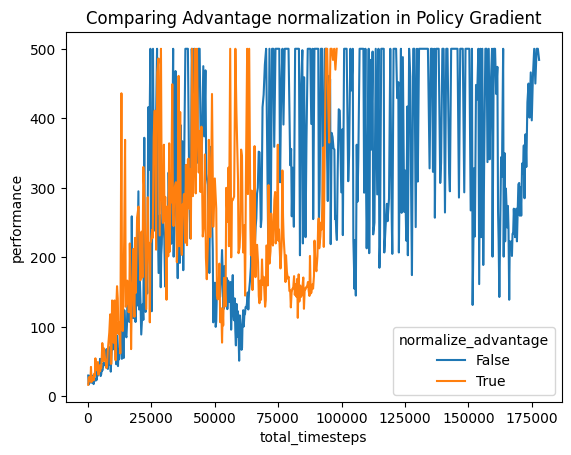

In [115]:
# Run this cell without modification

pg_result_no_na_df = pd.DataFrame(pg_result_no_na)
pg_result_with_na_df = pd.DataFrame(pg_result_with_na)
pg_result_no_na_df["normalize_advantage"] = False
pg_result_with_na_df["normalize_advantage"] = True

ax = sns.lineplot(
    x="total_timesteps",
    y="performance",
    data=pd.concat([pg_result_no_na_df, pg_result_with_na_df]).reset_index(), hue="normalize_advantage",
)
ax.set_title("Comparing Advantage normalization in Policy Gradient")
# It's OK to see very noisy curves...
# And you probably can't see clear margin...
# Running with more seeds might help.

### Section 4.4: Train REINFORCE in MetaDrive-Easy

In [116]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Easy-v0"

pg_trainer_metadrive_easy, pg_trainer_metadrive_easy_result = run(PGTrainer, dict(
    train_batch_size=2000,
    normalize_advantage=True,
    max_episode_length=200,
    max_iteration=5000,
    evaluate_interval=10,
    evaluate_num_episodes=10,
    learning_rate=0.001,
    clip_norm=10.0,
    env_name=env_name
), reward_threshold=120)

pg_trainer_metadrive_easy.save("pg_trainer_metadrive_easy.pt")
# Expected to converge within 100 iterations.

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 200
Training:   1%|          | 60/5001 [03:07<4:17:54,  3.13s/it, ep_reward=125]

Environment is closed.


In [117]:
# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pg_trainer_metadrive_easy.policy,
    num_episodes=1,
    env_name=pg_trainer_metadrive_easy.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

animate(eval_info["frames"])

print("REINFORCE agent achieves {} return in MetaDrive easy environment.".format(eval_reward))

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 200


Evaluating 1/1 episodes. We are in 1/1000 steps. Current episode reward: 0.008
Evaluating 1/1 episodes. We are in 51/1000 steps. Current episode reward: 37.142


REINFORCE agent achieves 125.05254010105511 return in MetaDrive easy environment.


## Section 5: Policy gradient with baseline

(20 / 100 points)

In REINFORCE, we compute the gradient of $Q = \mathop{\mathbb E} \sum_t r(a_t, s_t)$ w.r.t. the parameter to update the policy. Let's consider this case: when you take an "average" action that leads to a positive expected return, the policy gradient is also positive and you will update your network toward this action. At the same time, there might be a potentially better action. You should update the policy toward the better action instead of the "average" action. Do we have any way to impose the idea that we should at least update the policy toward an action that is better than the literally "average" action?

We introduce the "baseline" when computing the policy gradient. The insight behind this is that we want to optimize the policy toward an action that are better than the "average action". We introduce $b_{t} = \mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}$ as the baseline. It averages the expected discount return of all possible actions at state $s_t$. So that the "advantage" compared against the average action (aka the "excess profit") achieved by action $a_t$ can be evaluated via $\sum_{t'=t} \gamma^{t' -t}r(a_{t'}, s_{t'}) - b_t$

Therefore, the policy gradient becomes:

$$\nabla_\theta Q =\cfrac{1}{N}\sum_{i=1}^N [( \sum_t  \nabla_\theta \log \pi_\theta(a_{i,t}|s_{i,t}) (\sum_{t'} \gamma^{t'-t} r(s_{i,{t’}}, a_{i,t‘}) - b_{i, t})]$$

In our implementation, we estimate the baseline via an extra network `self.baseline`, which has same structure of the policy network but outputs only a scalar value. We use the output of this network to serve as the baseline, while this network is updated by fitting the true value of the expected return of current state: $\mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}$

The state-action values might have large variance if the reward function has large variance. It is not easy for a neural network to predict targets with large variance and extreme values. In our implementation, we use a trick to match the distribution of the baseline and values. During training, we first collect a batch of target values: $\{t_i= \mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}\}_i$. Then we normalize all targets to a standard Normal distribution with mean = 0 and std = 1. Then we ask the baseline network to fit such normalized targets.

When computing the advantages, instead of using the output of baseline network as the baseline $b$, we firstly match the baseline distribution (which, assume the baseline network is well trained, should be a standard Normal distribution) with the state-action values' distribution. We "de-standarize" the baselines. The transformed baselines $b' = f(b)$ should has the same mean and STD with the state-action values. By doing this, we mitigate the instability of training baseline.

After that, we compute the advantage of current action: $adv_{i,t} = \sum_{t'} \gamma^{t'-t} r(s_{i,{t'}}, a_{i,t'}) - b'_{i, t}$

Hint: We suggest to normalize an array via: `(x - x.mean()) / max(x.std(), 1e-6)`. The max term can mitigate numeraical instability.

### Section 5.1: Build PG method with baseline

In [136]:
# Finish TODOs

class PolicyGradientWithBaselineTrainer(PGTrainer):
    def initialize_parameters(self):
        # Build the actor in name of self.policy
        super().initialize_parameters()

        # TODO: Build the baseline network using PytorchModel class.
        self.baseline = PytorchModel(self.obs_dim, 1, self.config["hidden_units"]).to(self.device)

        self.baseline_loss = nn.MSELoss()

        self.baseline_optimizer = torch.optim.Adam(
            self.baseline.parameters(),
            lr=self.config["learning_rate"]
        )

    def process_samples(self, samples):
        # Call the original process_samples function to get advantages
        tmp_samples, _ = super().process_samples(samples)
        values = tmp_samples["advantages"]
        samples["values"] = values  # We add q_values into samples

        # Flatten the observations in all trajectories (still a numpy array)
        obs = np.concatenate(samples["obs"])

        assert obs.ndim == 2
        assert obs.shape[1] == self.obs_dim

        obs = self.to_tensor(obs)
        samples["flat_obs"] = obs

        # TODO: Compute the baseline by feeding observation to the baseline network
        # Hint: baselines should be a numpy array with the same shape of `values` (batch size, )
        baselines = self.to_array(self.baseline(obs)).squeeze(1)
        # print(baselines.shape)
        # print(values.shape)

        assert baselines.shape == values.shape

        # TODO: Match the distribution of baselines to the values.
        # Hint: We expect to see baselines.std() almost equals to values.std(), 
        #  and baselines.mean() almost equals to values.mean().
        baselines = (baselines - baselines.mean()) / max(baselines.std(), 1e-6) * values.std() + values.mean()
        # print(values.shape)
        # Compute the advantage
        advantages = values - baselines
        samples["advantages"] = advantages
        process_info = {"mean_baseline": float(np.mean(baselines))}
        return samples, process_info

    def update_network(self, processed_samples):
        update_info = super().update_network(processed_samples)
        update_info.update(self.update_baseline(processed_samples))
        return update_info

    def update_baseline(self, processed_samples):
        self.baseline.train()
        obs = processed_samples["flat_obs"]

        # TODO: Normalize `values` to have mean=0, std=1.
        values = processed_samples["values"]
        values = (values - values.mean()) / max(values.std(), 1e-6)

        values = self.to_tensor(values[:, np.newaxis])
        # print(values.shape)
        baselines = self.baseline(obs)

        self.baseline_optimizer.zero_grad()
        loss = self.baseline_loss(input=baselines, target=values)
        loss.backward()

        # Clip the gradient
        torch.nn.utils.clip_grad_norm_(
            self.baseline.parameters(), self.config["clip_gradient"]
        )

        self.baseline_optimizer.step()
        self.baseline.eval()
        return dict(baseline_loss=loss.item())


### Section 5.2: Run PG w/ baseline in CartPole

In [137]:
# Run this cell without modification

pg_trainer_wb_cartpole, pg_trainer_wb_cartpole_result = run(PolicyGradientWithBaselineTrainer, dict(
    learning_rate=0.001,
    max_episode_length=200,
    train_batch_size=200,

    env_name="CartPole-v1",
    normalize_advantage=True,

    evaluate_interval=10,
    evaluate_num_episodes=10,
), 195.0)


Training:   0%|          | 0/1001 [00:00<?, ?it/s]C:\Users\lucaslan\miniconda3\envs\rl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lucaslan\miniconda3\envs\rl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Training:  15%|█▍        | 150/1001 [00:07<00:43, 19.45it/s, ep_reward=198]

Environment is closed.


### Section 5.3: Run PG w/ baseline in MetaDrive-Easy


In [138]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Easy-v0"

pg_trainer_wb_metadrive_easy, pg_trainer_wb_metadrive_easy_result = run(
    PolicyGradientWithBaselineTrainer,
    dict(
        train_batch_size=2000,
        normalize_advantage=True,
        max_episode_length=200,
        max_iteration=5000,
        evaluate_interval=10,
        evaluate_num_episodes=10,
        learning_rate=0.001,
        clip_norm=10.0,
        env_name=env_name
    ),
    reward_threshold=120
)

pg_trainer_wb_metadrive_easy.save("pg_trainer_wb_metadrive_easy.pt")

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 200
Training:   1%|          | 30/5001 [01:35<4:23:42,  3.18s/it, ep_reward=125]

Environment is closed.


In [139]:
# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pg_trainer_wb_metadrive_easy.policy,
    num_episodes=1,
    env_name=pg_trainer_wb_metadrive_easy.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

print(
    "PG agent achieves {} return and {} success rate in MetaDrive easy environment.".format(
        eval_reward, eval_info["success_rate"]
    )
)

animate(eval_info["frames"])

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 200


Evaluating 1/1 episodes. We are in 1/1000 steps. Current episode reward: 0.008
Evaluating 1/1 episodes. We are in 51/1000 steps. Current episode reward: 37.142
PG agent achieves 125.05254010105511 return and 1.0 success rate in MetaDrive easy environment.


### Section 5.4: Run PG with baseline in MetaDrive-Hard

**The minimum goal to is to achieve episodic return > 20, which costs nearly 20 iterations and ~100k steps.**

You can try to play with hyperparameters and optimize code to see if you can achieve >0.0 success rate.

In [140]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Hard-v0"

pg_trainer_wb_metadrive_hard, pg_trainer_wb_metadrive_hard_result = run(
    PolicyGradientWithBaselineTrainer,
    dict(
        train_batch_size=4000,
        normalize_advantage=True,
        max_episode_length=1000,
        max_iteration=5000,
        evaluate_interval=5,
        evaluate_num_episodes=10,
        learning_rate=0.001,
        clip_norm=10.0,
        env_name=env_name
    ),
    reward_threshold=20  # We just set the reward threshold to 20. Feel free to adjust it.
)

pg_trainer_wb_metadrive_hard.save("pg_trainer_wb_metadrive_hard.pt")

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
Training:   0%|          | 10/5001 [02:59<24:51:57, 17.94s/it, ep_reward=23.9]

Environment is closed.


In [ ]:
# Run this cell without modification
# print(torch.cuda.is_available())
# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pg_trainer_wb_metadrive_hard.policy,
    num_episodes=10,
    env_name=pg_trainer_wb_metadrive_hard.env_name,
    render=None,
    verbose=False
)

_, eval_info_render = evaluate(
    policy=pg_trainer_wb_metadrive_hard.policy,
    num_episodes=1,
    env_name=pg_trainer_wb_metadrive_hard.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

print(
    "PG agent achieves {} return and {} success rate in MetaDrive easy environment.".format(
        eval_reward, eval_info["success_rate"]
    )
)

animate(eval_info_render["frames"])

In [146]:
print(torch.cuda.is_available())


False


------

## Conclusion

In this assignment, we learn how to build naive Q learning, Deep Q Network and Policy Gradient methods.

Following the submission instruction in the assignment to submit your assignment. Thank you!

------